# DiffusionNet FiniteNet Section plots

## Imports

In [1]:
import matplotlib.pyplot as plt
import torch
import tensorflow
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import sklearn
import sklearn.metrics
from tqdm.notebook import tqdm

In [2]:
# load finiteNet 1000 test results
import pickle
testSamples= pickle.load(open('Samples//1000TestSamples.pkl','rb')) 

In [8]:
#load our model
loaded_model = tensorflow.keras.models.load_model('Models//burger std=0.7968797813840656 mean=1.4804453986909523 loss=0.0019.h5' ,custom_objects={'LeakyReLU':tensorflow.keras.layers.LeakyReLU()})
std  = 0.7968797813840656
mean = 1.4804453986909523

In [9]:
def predict_batch(x,model,steps):
    '''
    Input
    x     : Input array (sample,frame,row,cols,channel)
    steps : prediction steps
    model : predictor
    
    Output
    array of solutions predictions at steps of size (sample,steps+1,rows,cols,channel)
    '''
    samples,frames,rows,cols,channel = x.shape
    predictions=np.zeros((samples,steps+1,rows,cols,channel)) #result array for prediction stream including inital step +1
    predictions[:,[0]] = x  #inital input is included
    for i in range(steps): predictions[:,[i+1]] = model.predict(predictions[:,[i]]) # predict recursively
    return predictions

def predict_batches(initial_inputs,prediction_indices , prediction_step,model,total_frames):
    '''
    Input 
    initial input : the inital solution(s) to be predicted
    prediction step : model defined step
    total_length : number of frames of solution ( including initial conditions )
    
    Output
    dictionary of prediction streams    
    '''
    result = {}
    
    si,fi,ri,ci,cci = initial_inputs.shape
    
    for i in prediction_indices:
        # parallelizable step
        initial_input  = initial_inputs[:,[i]]
        steps = (total_frames-i-1)//prediction_step    # len(np.arange(i,total_frames,prediction_step)) -1    
        result[i] = predict_batch(initial_input,model=loaded_model,steps = steps)
    return result

def add_batches(batches,shape,step,std=1,mean=0):
    '''
    Input : 
        Batches: Solution batches 
        Shape : Shape of the result (sample,total frame,rows,cols,channels)
        Step  : Step of prediction
    
    Output :
        Solution
    '''
    result = np.zeros(shape)
    
    for key in batches :
        # a batch key is the initial index of their respective solution
        batch = batches[key]
        indices = np.arange(key,shape[1],step)
        result[:,[indices]] = batch
    return ( result * std ) + mean



In [105]:
model_input = testSamples[0]['output_we'].data.numpy()[0,:10].reshape(1,10,10,10,1) # First 10 from WENO5 as input
model_input = ( model_input - mean ) / std  # standardize
pad_input = np.zeros((1,10,12,12,1))   # pad the input
pad_input[:,:,1:-1,1:-1,:] = model_input
solution_batches = predict_batches(pad_input,prediction_indices=[0],prediction_step=10,model=loaded_model,total_frames=101)
# final_solution = ((solution_streams[0][:,:,1:-1,1:-1,:] * std)+mean)

## Compute DiffusionNet predictions

## Full prediction

In [33]:
model_input = testSamples[0]['output_we'].data.numpy()[0,:10].reshape(1,10,10,10,1) #first 10 as input
model_input = ( model_input - mean ) / std
pad_input = np.zeros((1,10,12,12,1))
pad_input[:,:,1:-1,1:-1,:] = model_input

solution_batches = predict_batches(pad_input,
                                   prediction_indices=[0],#np.arange(10),
                                   prediction_step=10,
                                   model=loaded_model,
                                   total_frames=101)

combined_batches = add_batches(solution_batches , shape = (1,101,12,12,1) ,step = 10 , mean = mean , std= std)[:,:,1:-1,1:-1,:]

In [12]:
parts = {}
for part_number in range(10):
    result ={}
    selected_indices = np.arange(10+part_number,101,10)
    tests = 1000 

    for i in tqdm(range(tests)):

        weno   = testSamples[i]['output_we'].data.numpy()[0,selected_indices].reshape(-1,1)
        finite = testSamples[i]['output'].data.numpy()[0,selected_indices].reshape(-1,1)
        target = testSamples[i]['target_seq'].data.numpy()[0,selected_indices].reshape(-1,1)

        mse_weno = sklearn.metrics.mean_squared_error(weno,target)
        mse_finite =  sklearn.metrics.mean_squared_error(finite,target)

        ### model prediction
        model_input = testSamples[i]['output_we'].data.numpy()[0,:10].reshape(1,10,10,10,1) #first 10 as input
        
        model_input = ( model_input - mean ) / std
        pad_input = np.zeros((1,10,12,12,1))
        pad_input[:,:,1:-1,1:-1,:] = model_input
        
        solution_batches = predict_batches(pad_input,
                                           prediction_indices=[part_number],
                                           prediction_step=10,
                                           model=loaded_model,
                                           total_frames=101)
        
        
        solution_batch = ((solution_batches[part_number][:,1:,1:-1,1:-1,:] * std)+mean).reshape(-1,1)
        mse_diffusion = sklearn.metrics.mean_squared_error(solution_batch,target)

        result[i] = {'mse_weno':mse_weno,'mse_finite':mse_finite,'mse_diffusion':mse_diffusion}
    
    parts[part_number] = result

KeyboardInterrupt: 

import pickle 
pickle.dump(parts, open('parts.pkl','wb'))

## Error for each batch

In [133]:
error_diff_weno   = np.zeros((10,1000))
error_diff_finite = np.zeros((10,1000))
error_finite_weno = np.zeros((10,1000))
    
for parts_range in range(10):
    for i in range(1000):
        error_diff_weno[parts_range][i] = parts[parts_range][i]['mse_diffusion'] /parts[parts_range][i]['mse_weno']
        error_finite_weno[parts_range][i] = parts[parts_range][i]['mse_finite'] /parts[parts_range][i]['mse_weno']
        error_diff_finite[parts_range][i] = parts[parts_range][i]['mse_diffusion'] /parts[parts_range][i]['mse_finite']


    for thresh in [1]:#,0.5,0.25,0.125]:
        print(f'\nThreshold<{thresh},part = {parts_range}')
        print( 'DiffusionNet with WENO5 on 100 steps:' ,    error_diff_weno[parts_range][error_diff_weno[parts_range]<thresh].shape )
        print( 'FiniteNet with WENO5 on 100 steps:' ,       error_finite_weno[parts_range][error_finite_weno[parts_range]<thresh].shape )
        print( 'DiffusionNet with FiniteNet on 100 steps:' ,error_diff_finite[parts_range][error_diff_finite[parts_range]<thresh].shape )


Threshold<1,part = 0
DiffusionNet with WENO5 on 100 steps: (837,)
FiniteNet with WENO5 on 100 steps: (998,)
DiffusionNet with FiniteNet on 100 steps: (429,)

Threshold<1,part = 1
DiffusionNet with WENO5 on 100 steps: (863,)
FiniteNet with WENO5 on 100 steps: (997,)
DiffusionNet with FiniteNet on 100 steps: (480,)

Threshold<1,part = 2
DiffusionNet with WENO5 on 100 steps: (863,)
FiniteNet with WENO5 on 100 steps: (997,)
DiffusionNet with FiniteNet on 100 steps: (457,)

Threshold<1,part = 3
DiffusionNet with WENO5 on 100 steps: (872,)
FiniteNet with WENO5 on 100 steps: (996,)
DiffusionNet with FiniteNet on 100 steps: (496,)

Threshold<1,part = 4
DiffusionNet with WENO5 on 100 steps: (861,)
FiniteNet with WENO5 on 100 steps: (997,)
DiffusionNet with FiniteNet on 100 steps: (469,)

Threshold<1,part = 5
DiffusionNet with WENO5 on 100 steps: (860,)
FiniteNet with WENO5 on 100 steps: (998,)
DiffusionNet with FiniteNet on 100 steps: (470,)

Threshold<1,part = 6
DiffusionNet with WENO5 on 100

## Error for some Batches

In [160]:
half_parts = {}
batches = [0]
for ti in range(1000):
    half_parts[ti]= { 'mse_diffusion' : np.mean([parts[pi][ti]['mse_diffusion'] for pi in batches]) , 
                          'mse_finite'    : np.mean([parts[pi][ti]['mse_finite'] for pi in batches])    ,
                           'mse_weno'     : np.mean([parts[pi][ti]['mse_weno'] for pi in batches])} 

In [161]:
#combined error thresholds
error_diff_weno_half   = np.zeros(1000)
error_diff_finite_half = np.zeros(1000)
error_finite_weno_half = np.zeros(1000)

for i in range(1000):
    error_diff_weno_half[i] = half_parts[i]['mse_diffusion'] /half_parts[i]['mse_weno']
    error_finite_weno_half[i] = half_parts[i]['mse_finite'] /half_parts[i]['mse_weno']
    error_diff_finite_half[i] = half_parts[i]['mse_diffusion'] /half_parts[i]['mse_finite']
    

for thresh in [1,0.5,0.25,0.125]:
    print(f'\nThreshold<{thresh}')
    print( 'DiffusionNet with WENO5 on 100 steps:' ,    error_diff_weno_half[error_diff_weno_half<thresh].shape )
    print( 'FiniteNet with WENO5 on 100 steps:' ,       error_finite_weno_half[error_finite_weno_half<thresh].shape )
    print( 'DiffusionNet with FiniteNet on 100 steps:' ,error_diff_finite_half[error_diff_finite_half<thresh].shape )


Threshold<1
DiffusionNet with WENO5 on 100 steps: (837,)
FiniteNet with WENO5 on 100 steps: (998,)
DiffusionNet with FiniteNet on 100 steps: (429,)

Threshold<0.5
DiffusionNet with WENO5 on 100 steps: (642,)
FiniteNet with WENO5 on 100 steps: (970,)
DiffusionNet with FiniteNet on 100 steps: (203,)

Threshold<0.25
DiffusionNet with WENO5 on 100 steps: (360,)
FiniteNet with WENO5 on 100 steps: (284,)
DiffusionNet with FiniteNet on 100 steps: (72,)

Threshold<0.125
DiffusionNet with WENO5 on 100 steps: (180,)
FiniteNet with WENO5 on 100 steps: (1,)
DiffusionNet with FiniteNet on 100 steps: (17,)


## Error for all Batches

In [135]:
combined_parts = {}

for ti in range(1000):
    combined_parts[ti]= { 'mse_diffusion' : np.mean([parts[pi][ti]['mse_diffusion'] for pi in range(10)]) , 
                          'mse_finite'    : np.mean([parts[pi][ti]['mse_finite'] for pi in range(10)])    ,
                           'mse_weno'     : np.mean([parts[pi][ti]['mse_weno'] for pi in range(10)])} 

In [137]:
#combined error thresholds
error_diff_weno_all   = np.zeros(1000)
error_diff_finite_all = np.zeros(1000)
error_finite_weno_all = np.zeros(1000)

for i in range(1000):
    error_diff_weno_all[i] = combined_parts[i]['mse_diffusion'] /combined_parts[i]['mse_weno']
    error_finite_weno_all[i] = combined_parts[i]['mse_finite'] /combined_parts[i]['mse_weno']
    error_diff_finite_all[i] = combined_parts[i]['mse_diffusion'] /combined_parts[i]['mse_finite']
    

for thresh in [1,0.5,0.25,0.125]:
    print(f'\nThreshold<{thresh}')
    print( 'DiffusionNet with WENO5 on 100 steps:' ,    error_diff_weno_all[error_diff_weno_all<thresh].shape )
    print( 'FiniteNet with WENO5 on 100 steps:' ,       error_finite_weno_all[error_finite_weno_all<thresh].shape )
    print( 'DiffusionNet with FiniteNet on 100 steps:' ,error_diff_finite_all[error_diff_finite_all<thresh].shape )


Threshold<1
DiffusionNet with WENO5 on 100 steps: (947,)
FiniteNet with WENO5 on 100 steps: (1000,)
DiffusionNet with FiniteNet on 100 steps: (168,)

Threshold<0.5
DiffusionNet with WENO5 on 100 steps: (575,)
FiniteNet with WENO5 on 100 steps: (980,)
DiffusionNet with FiniteNet on 100 steps: (8,)

Threshold<0.25
DiffusionNet with WENO5 on 100 steps: (101,)
FiniteNet with WENO5 on 100 steps: (169,)
DiffusionNet with FiniteNet on 100 steps: (1,)

Threshold<0.125
DiffusionNet with WENO5 on 100 steps: (5,)
FiniteNet with WENO5 on 100 steps: (0,)
DiffusionNet with FiniteNet on 100 steps: (0,)


## Error histograms

In [141]:
mpl.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})
mpl.rcParams['figure.dpi'] = 72;mpl.rcParams.update({'font.size': 15});mpl.rcParams['axes.linewidth'] = 2
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 

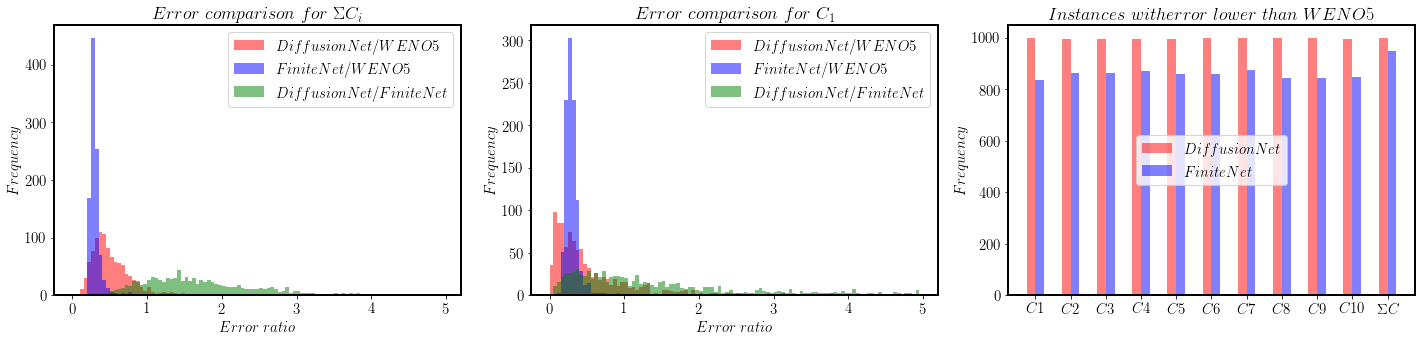

In [168]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.hist(error_diff_weno_all,bins=np.arange(0,5,0.05),alpha=0.5 ,label = '$DiffusionNet/WENO5$',color='red') 
plt.hist(error_finite_weno_all,bins=np.arange(0,5,0.05),alpha=0.5 ,label = '$FiniteNet/WENO5$',color='blue')
plt.hist(error_diff_finite_all,bins=np.arange(0,5,0.05),alpha=0.5 ,label = '$DiffusionNet/FiniteNet$',color='green')

plt.ylabel('$Frequency$');plt.xlabel('$Error  \ ratio$')
plt.title('$Error \  comparison \ for \ \Sigma C_i$')

plt.legend()

plt.subplot(1,3,2)

plt.hist(error_diff_weno_half,bins=np.arange(0,5,0.05),alpha=0.5 ,label = '$DiffusionNet/WENO5$',color='red') 
plt.hist(error_finite_weno_half,bins=np.arange(0,5,0.05),alpha=0.5 ,label = '$FiniteNet/WENO5$',color='blue')
plt.hist(error_diff_finite_half,bins=np.arange(0,5,0.05),alpha=0.5 ,label = '$DiffusionNet/FiniteNet$',color='green')

plt.ylabel('$Frequency$');plt.xlabel('$Error  \ ratio$')
plt.title('$Error \ comparison \  for \  C_1$')

plt.legend()


plt.subplot(1,3,3)
f_bars= [ error_finite_weno[j][error_finite_weno[j]<1].shape[0] for j in range(10) ]
f_bars.append(error_finite_weno_all[error_finite_weno_all<1].shape[0])
d_bars= [ error_diff_weno[j][error_diff_weno[j]<1].shape[0] for j in range(10) ]
d_bars.append(error_diff_weno_all[error_diff_weno_all<1].shape[0])
fd_bars= [ error_diff_finite[j][error_diff_finite[j]<1].shape[0] for j in range(10) ]
fd_bars.append(error_diff_finite_all[error_diff_finite_all<1].shape[0])
N = 11
finite = f_bars  #(error_finite_weno[0][error_finite_weno[0]<1].shape, 35, 30, 35, 27)
diffusion = d_bars
diffusionFinite=fd_bars

ind = np.arange(N) 
width = 0.25       
plt.bar(ind, finite, width, label='$DiffusionNet$',color='red',alpha=0.5)
plt.bar(ind + width, diffusion, width,label='$FiniteNet$',color='blue',alpha=0.5)
# plt.bar(ind + 2*width, diffusionFinite, width,label='$FiniteNet$',color='green',alpha=0.5)
plt.ylabel('$Frequency$')
plt.title('$Instances \ with error \ lower \ than \ WENO5$')

plt.xticks(ind + width / 2, ('$C1$','$C2$','$C3$','$C4$','$C5$','$C6$','$C7$','$C8$','$C9$','$C10$','$\Sigma C$'))
plt.legend(loc='center')


plt.tight_layout()
plt.savefig('Histogram.svg')

## Sample plot

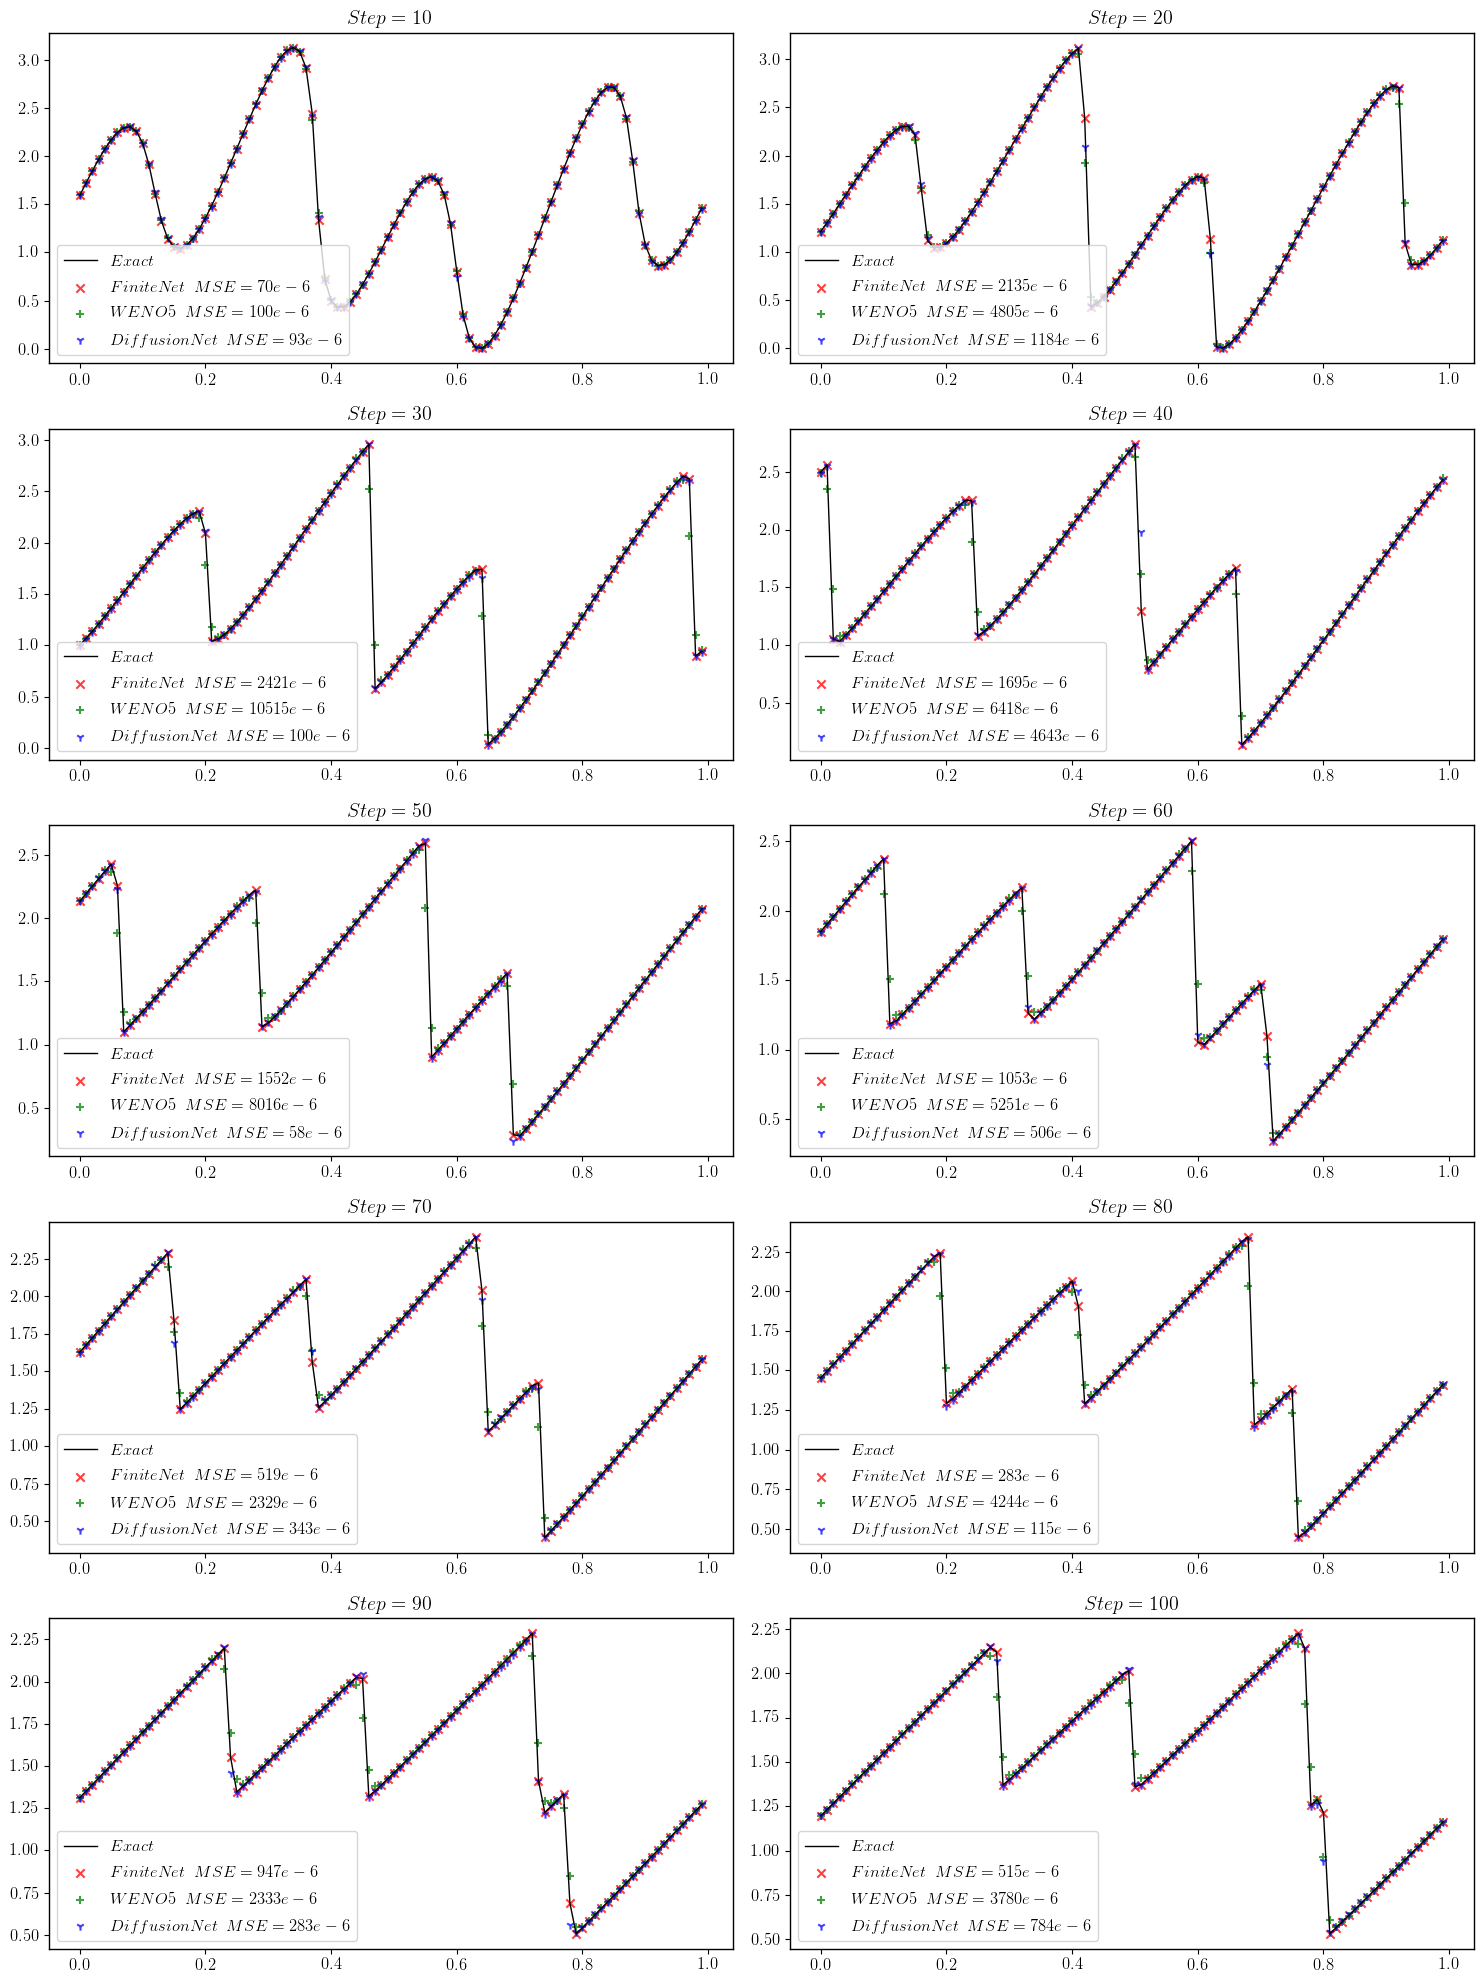

In [62]:
mpl.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})
mpl.rcParams['figure.dpi'] = 100;mpl.rcParams.update({'font.size': 12});mpl.rcParams['axes.linewidth'] = 1
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 

#load sample data from FiniteNet
def load(path):return pickle.load(open(path,'rb'))
exactSolution,finiteNetSolution,WENO5Solution = load('Samples//sampleExactSolution.pkl') , load('Samples//sampleFiniteNetSolution.pkl')  ,load('Samples//sampleWENO5Solution.pkl') 
exactSolution,finiteNetSolution,WENO5Solution= exactSolution.data.numpy() ,finiteNetSolution.data.numpy(),WENO5Solution.data.numpy()



model_input = WENO5Solution[0,0].reshape(1,1,10,10,1) #first 10 as input
model_input = ( model_input - mean ) / std
pad_input = np.zeros((1,10,12,12,1))
pad_input[:,:,1:-1,1:-1,:] = model_input

solution_batches = predict_batches(pad_input,
                                   prediction_indices=[0],
                                   prediction_step=10,
                                   model=loaded_model,
                                   total_frames=101)

combined_batches = add_batches(solution_batches , shape = (1,101,12,12,1) ,step = 10 , mean = mean , std= std)[:,:,1:-1,1:-1,:]

t= np.arange(0,1,0.01)
plt.figure(figsize=(15,20))
for i in range(1,11):
    
    
    exactSolutionFlatten = exactSolution[:,10*i,:].reshape(100)
    finiteNetSolutionFlatten = finiteNetSolution[:,10*i,:].reshape(100)
    WENO5SolutionFlatten = WENO5Solution[:,10*i,:].reshape(100)
    diffusionSolutionFlatten = combined_batches[:,10*i].reshape(100) 

    WENO_MSE = np.round(sklearn.metrics.mean_squared_error(WENO5SolutionFlatten,exactSolutionFlatten),6)*10**6
    FiniteNeT_MSE = np.round(sklearn.metrics.mean_squared_error(finiteNetSolutionFlatten,exactSolutionFlatten),6)*10**6
    DiffusionNet_MSE = np.round(sklearn.metrics.mean_squared_error(diffusionSolutionFlatten,exactSolutionFlatten),6)*10**6
    
    plt.subplot(5,2,i)
    
    plt.plot(   t,exactSolutionFlatten,'-k' ,linewidth=1)
    plt.scatter(t,exactSolutionFlatten    ,alpha=.75,color='red',marker='x')
    plt.scatter(t,WENO5SolutionFlatten    ,alpha=.75,color='green',marker='+')
    plt.scatter(t,diffusionSolutionFlatten,alpha=.75,color='blue',marker='1')
    
    plt.title(f'$Step={i*10} $')
    
    plt.tight_layout()
    plt.legend(['$Exact$',f'$FiniteNet \ \ MSE={int(FiniteNeT_MSE)}e-6$',f'$WENO5 \ \  MSE={int(WENO_MSE)}e-6$',f'$DiffusionNet \ \ MSE={int(DiffusionNet_MSE)}e-6$'])
    

plt.savefig('dfn.svg')